In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

In [2]:

# Đọc dữ liệu
df = pd.read_csv('Heating Oil.csv')

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)


In [3]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,2.001,2.0293,2.0479,1.9791,55010.0,-1.11
1,2019-03-02 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
2,2019-03-03 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
3,2019-03-04 00:00:00,2.0143,1.9999,2.0377,1.9984,56050.0,0.66
4,2019-03-05 00:00:00,2.0164,2.011,2.0229,1.9909,45160.0,0.1
...,...,...,...,...,...,...,...
1914,2024-05-27 00:00:00,2.451,2.4361,2.466,2.4302,NaN,0.63
1915,2024-05-28 00:00:00,2.465,2.4148,2.48,2.4131,28960.0,0.57
1916,2024-05-29 00:00:00,2.437,2.4801,2.4935,2.4295,22870.0,-1.14
1917,2024-05-30 00:00:00,2.3694,2.4305,2.4368,2.3637,18120.0,-2.77


In [4]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna()
df = df.reset_index(drop=True)

price = df['Price'].values
price = price.reshape(-1, 1)

In [5]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Heating Oil


## 7:3

In [6]:
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [7]:
# Hàm tạo tập dữ liệu với look_back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)


In [8]:
look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Định hình lại dữ liệu để phù hợp với mô hình
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [9]:
# Huấn luyện mô hình
model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    max_features='sqrt', 
    random_state=42
)
model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', random_state=42)

In [10]:
# Dự báo 
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

In [11]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
test_score_mape = mean_absolute_percentage_error(Y_test, test_predict) * 100
test_score_mae = mean_absolute_error(Y_test, test_predict)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.21799907142913372
MAPE trên tập test là: 5.950587952273746 %
MAE trên tập test là: 0.16848177892373908


In [12]:

# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-look_back:]
next_90_days = []

for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat.reshape(-1,1), axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print("Dự báo giá trị 90 ngày trong tương lai:")
print(next_90_days)

Dự báo giá trị 90 ngày trong tương lai:
[[2.39461015]
 [2.37737519]
 [2.36354597]
 [2.35762586]
 [2.36342426]
 [2.34786002]
 [2.34054079]
 [2.32319617]
 [2.30604706]
 [2.30454122]
 [2.29862307]
 [2.28814092]
 [2.28534726]
 [2.29304833]
 [2.29140994]
 [2.28069848]
 [2.278478  ]
 [2.30641513]
 [2.32563646]
 [2.34061605]
 [2.34591587]
 [2.34780054]
 [2.35408054]
 [2.36221744]
 [2.37958438]
 [2.38680076]
 [2.38252225]
 [2.36888441]
 [2.36781193]
 [2.37718408]
 [2.38298972]
 [2.37824485]
 [2.3683831 ]
 [2.37926497]
 [2.37841359]
 [2.37053549]
 [2.36994073]
 [2.3714304 ]
 [2.37089582]
 [2.37026299]
 [2.36969252]
 [2.37325588]
 [2.36248385]
 [2.36880337]
 [2.36828662]
 [2.36872997]
 [2.36339593]
 [2.36260477]
 [2.37120399]
 [2.36739831]
 [2.36813781]
 [2.36992766]
 [2.3743621 ]
 [2.37611541]
 [2.37138239]
 [2.37321828]
 [2.3754096 ]
 [2.37695485]
 [2.37658828]
 [2.37552816]
 [2.37376228]
 [2.37130403]
 [2.37709216]
 [2.37661578]
 [2.37459891]
 [2.36978216]
 [2.36972377]
 [2.37460641]
 [2.3722

In [13]:

test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)

next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1823,2.394610
1824,2.377375
1825,2.363546
1826,2.357626
1827,2.363424
...,...
1908,2.373752
1909,2.372759
1910,2.379493
1911,2.377793


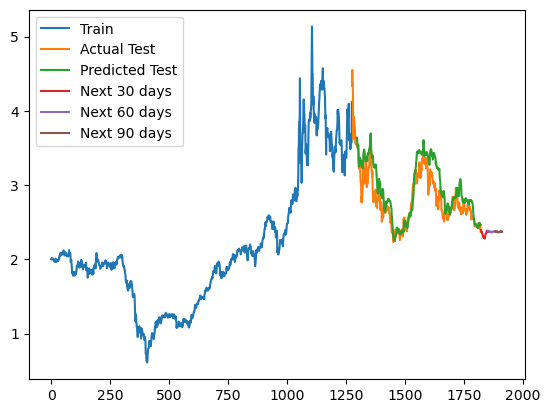

In [14]:

next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.savefig("RF_Heating_Oil_Week6.png")

plt.legend()
plt.show()

## 8:2

In [15]:
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled) * 0.2)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [16]:

# Hàm tạo tập dữ liệu với look_back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Định hình lại dữ liệu để phù hợp với mô hình
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [17]:
# Huấn luyện mô hình
model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    max_features='sqrt', 
    random_state=42
)
model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', random_state=42)

In [18]:
# Dự báo 
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

In [19]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
test_score_mape = mean_absolute_percentage_error(Y_test, test_predict) * 100
test_score_mae = mean_absolute_error(Y_test, test_predict)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.06937633553622462
MAPE trên tập test là: 1.8592282593895628 %
MAE trên tập test là: 0.05222219629618983


In [20]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-look_back:]
next_90_days = []

for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat.reshape(-1,1), axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print("Dự báo giá trị 90 ngày trong tương lai:")
print(next_90_days)


Dự báo giá trị 90 ngày trong tương lai:
[[2.37579017]
 [2.36847911]
 [2.35745858]
 [2.35529647]
 [2.34460383]
 [2.3336307 ]
 [2.32767189]
 [2.33648956]
 [2.33497186]
 [2.33036887]
 [2.34838642]
 [2.34817455]
 [2.34463342]
 [2.35158014]
 [2.35743026]
 [2.34294153]
 [2.34337414]
 [2.35650864]
 [2.36042811]
 [2.36470468]
 [2.36676127]
 [2.36340649]
 [2.36634632]
 [2.36594486]
 [2.36520311]
 [2.36605786]
 [2.3664588 ]
 [2.3636918 ]
 [2.36600486]
 [2.3663343 ]
 [2.36318394]
 [2.36273036]
 [2.36273036]
 [2.361954  ]
 [2.364207  ]
 [2.364254  ]
 [2.36399262]
 [2.363137  ]
 [2.360322  ]
 [2.35991079]
 [2.35991079]
 [2.36003741]
 [2.36040341]
 [2.36071941]
 [2.36055841]
 [2.35932841]
 [2.35864641]
 [2.35864641]
 [2.35890491]
 [2.36013491]
 [2.36077592]
 [2.36077592]
 [2.35954592]
 [2.35890491]
 [2.35890491]
 [2.35890491]
 [2.35890491]
 [2.35954592]
 [2.35954592]
 [2.35954592]
 [2.35954592]
 [2.35890491]
 [2.35890491]
 [2.35890491]
 [2.35890491]
 [2.35954592]
 [2.35954592]
 [2.35954592]
 [2.3595

In [21]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)

next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1823,2.375790
1824,2.368479
1825,2.357459
1826,2.355296
1827,2.344604
...,...
1908,2.358905
1909,2.358905
1910,2.358905
1911,2.358905


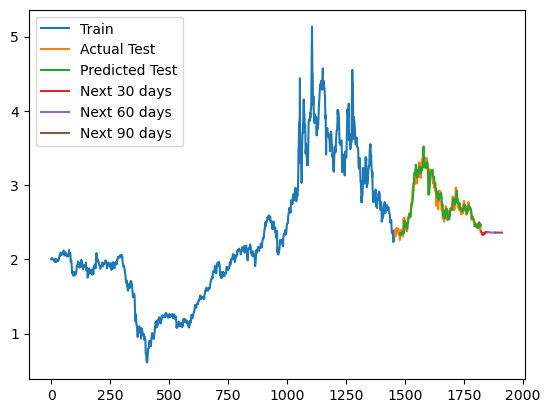

In [22]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.legend()
plt.show()

### 9:1

In [23]:
train_size = int(len(price_scaled) * 0.9)
test_size = int(len(price_scaled) * 0.1)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [24]:
# Hàm tạo tập dữ liệu với look_back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Định hình lại dữ liệu để phù hợp với mô hình
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [25]:
# Huấn luyện mô hình
model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    max_features='sqrt', 
    random_state=42
)
model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', random_state=42)

In [26]:
# Dự báo 
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

In [27]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
test_score_mape = mean_absolute_percentage_error(Y_test, test_predict) * 100
test_score_mae = mean_absolute_error(Y_test, test_predict)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.04933516942561394
MAPE trên tập test là: 1.3572366716176036 %
MAE trên tập test là: 0.036044941691809794


In [28]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-look_back:]
next_90_days = []

for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat.reshape(-1,1), axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print("Dự báo giá trị 90 ngày trong tương lai:")
print(next_90_days)


Dự báo giá trị 90 ngày trong tương lai:
[[2.38071877]
 [2.3631928 ]
 [2.35183623]
 [2.35136323]
 [2.35683931]
 [2.34395704]
 [2.3279677 ]
 [2.33961588]
 [2.332655  ]
 [2.34029281]
 [2.34303709]
 [2.34628353]
 [2.3448499 ]
 [2.35695631]
 [2.35702189]
 [2.35971718]
 [2.35667333]
 [2.3665874 ]
 [2.36614881]
 [2.36608749]
 [2.36731063]
 [2.36865176]
 [2.36806334]
 [2.36647047]
 [2.36505778]
 [2.35861754]
 [2.3607625 ]
 [2.36566161]
 [2.37072006]
 [2.37139893]
 [2.37132704]
 [2.36860082]
 [2.35777518]
 [2.35232108]
 [2.34936885]
 [2.35362637]
 [2.36740283]
 [2.37274251]
 [2.37491861]
 [2.37394464]
 [2.36598111]
 [2.35601294]
 [2.35288041]
 [2.35136427]
 [2.36327748]
 [2.37031258]
 [2.37544634]
 [2.37360411]
 [2.37230984]
 [2.35925413]
 [2.35600476]
 [2.35145836]
 [2.35209935]
 [2.36509601]
 [2.37361049]
 [2.37772088]
 [2.3726374 ]
 [2.36682174]
 [2.35621622]
 [2.35332303]
 [2.35074242]
 [2.36184874]
 [2.36943264]
 [2.37477106]
 [2.37426265]
 [2.37006709]
 [2.35638039]
 [2.35524263]
 [2.3512

In [29]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)

next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1823,2.380719
1824,2.363193
1825,2.351836
1826,2.351363
1827,2.356839
...,...
1908,2.352523
1909,2.349895
1910,2.363805
1911,2.372651


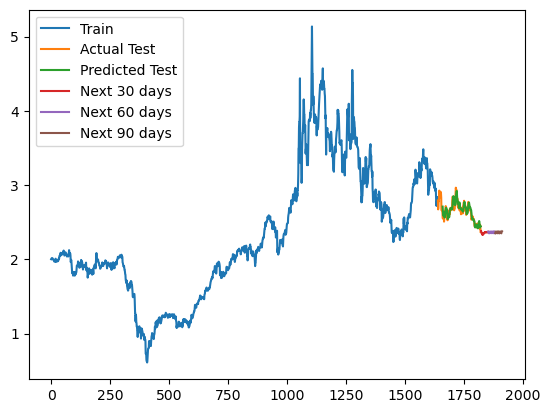

In [30]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.legend()
plt.show()